### IMPORT LIBRARIES

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# scikit-learn
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest


# evaluation metrics
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score



# scaling
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# autoencoder
import tensorflow as tf
from tensorflow import keras

# deep learning
from keras.models import Model, Sequential
from keras import regularizers
from keras.layers import (
    Input,
    Conv1D,
    MaxPooling1D,
    Dense,
    Flatten,
    Dropout,
    BatchNormalization,
)
from keras.optimizers import Adam
import tensorflow 
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras import models,layers,activations,losses,optimizers,metrics
from tensorflow.keras.callbacks import EarlyStopping

### LOADING DATASET

In [2]:
credit_card = pd.read_excel("card transactions.xlsx")

### DATA PREPROCESSING 

In [3]:
credit_card.shape

(96753, 10)

In [4]:
credit_card.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96753 entries, 0 to 96752
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Recnum             96753 non-null  int64         
 1   Cardnum            96753 non-null  int64         
 2   Date               96753 non-null  datetime64[ns]
 3   Merchnum           93378 non-null  object        
 4   Merch description  96753 non-null  object        
 5   Merch state        95558 non-null  object        
 6   Merch zip          92097 non-null  float64       
 7   Transtype          96753 non-null  object        
 8   Amount             96753 non-null  float64       
 9   Fraud              96753 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(4)
memory usage: 7.4+ MB


### EXTRACT DAY AND MONTH FOR FURTHER ANALYSIS

In [5]:
day =pd.to_datetime(credit_card['Date']).dt.dayofweek
month =pd.to_datetime(credit_card['Date']).dt.month
credit_card.insert(1, 'day', day)
credit_card.insert(2, 'month', month)

### DELETING IRRELEVANT COLUMNS

In [6]:
credit_card = credit_card.drop('Date', axis = 1)
credit_card = credit_card.drop('Recnum', axis = 1)
credit_card = credit_card.drop('Transtype', axis = 1)
credit_card = credit_card.drop('Merch zip', axis = 1)

### CHECKING FOR NULL VALUES

In [7]:
credit_card.isnull().sum()

day                     0
month                   0
Cardnum                 0
Merchnum             3375
Merch description       0
Merch state          1195
Amount                  0
Fraud                   0
dtype: int64

### DROP THE NULL VALUES

In [8]:
credit_card['Merchnum'] = credit_card['Merchnum'].dropna()
credit_card['Merch state'] = credit_card['Merch state'].dropna()

In [9]:
credit_card.isnull().sum()

day                     0
month                   0
Cardnum                 0
Merchnum             3375
Merch description       0
Merch state          1195
Amount                  0
Fraud                   0
dtype: int64

In [10]:
credit_card[['day', 'month','Amount']].describe()

,day,month,Amount
count,96753.000000,96753.000000,9.675300e+04
mean,2.563218,6.327215,4.278857e+02
std,2.101681,3.241349,1.000614e+04
min,0.000000,1.000000,1.000000e-02
25%,1.000000,4.000000,3.348000e+01
50%,2.000000,6.000000,1.379800e+02
75%,5.000000,9.000000,4.282000e+02
max,6.000000,12.000000,3.102046e+06


### UNIQUE VALUES

In [11]:
dict_unique = {}
for i in credit_card.columns.to_list():
    dict_unique[i]=len(credit_card[i].unique())
dict_unique

{'day': 7,
 'month': 12,
 'Cardnum': 1645,
 'Merchnum': 13092,
 'Merch description': 13126,
 'Merch state': 228,
 'Amount': 34909,
 'Fraud': 2}

### CHECKING FOR DUPLICATES

In [12]:
credit_card.duplicated().sum()

6898

### STATISTICS SUMMARY

In [13]:
credit_card.describe()

,day,month,Cardnum,Amount,Fraud
count,96753.000000,96753.000000,9.675300e+04,9.675300e+04,96753.000000
mean,2.563218,6.327215,5.142202e+09,4.278857e+02,0.010945
std,2.101681,3.241349,5.567084e+04,1.000614e+04,0.104047
min,0.000000,1.000000,5.142110e+09,1.000000e-02,0.000000
25%,1.000000,4.000000,5.142152e+09,3.348000e+01,0.000000
50%,2.000000,6.000000,5.142196e+09,1.379800e+02,0.000000
75%,5.000000,9.000000,5.142246e+09,4.282000e+02,0.000000
max,6.000000,12.000000,5.142847e+09,3.102046e+06,1.000000


### EXPLORING THE DATASET

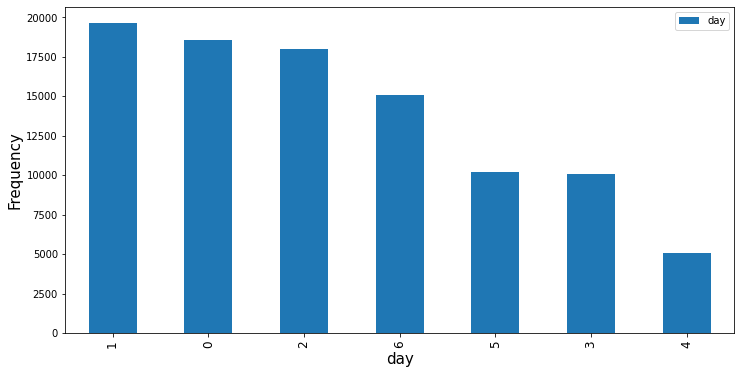

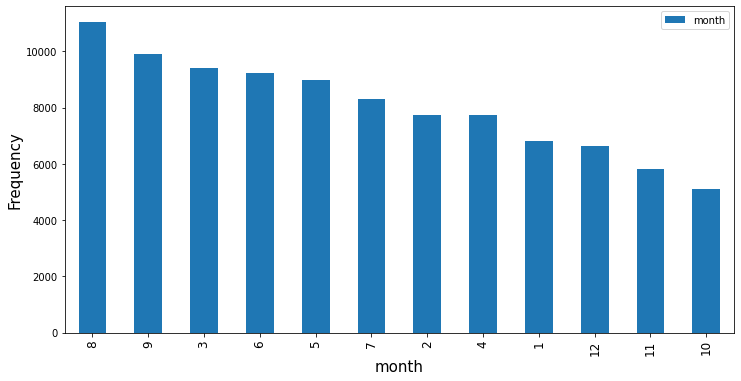

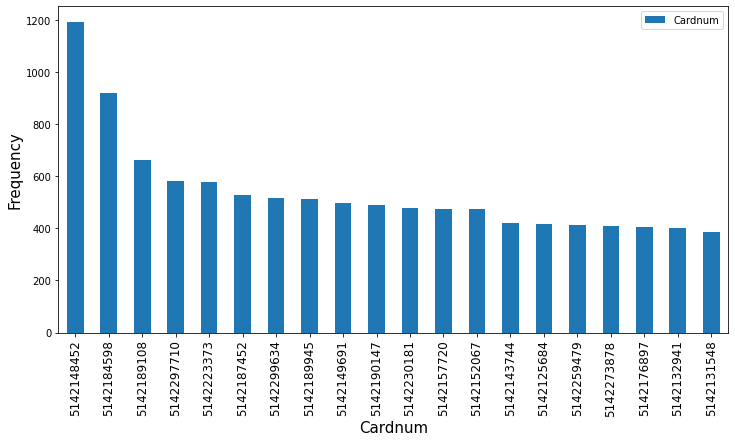

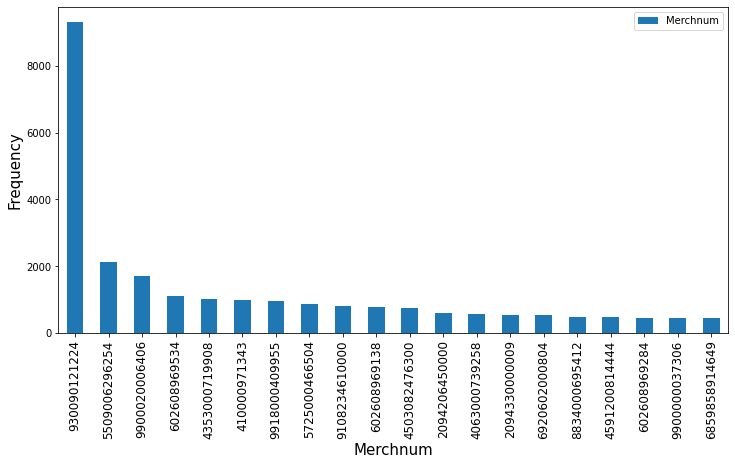

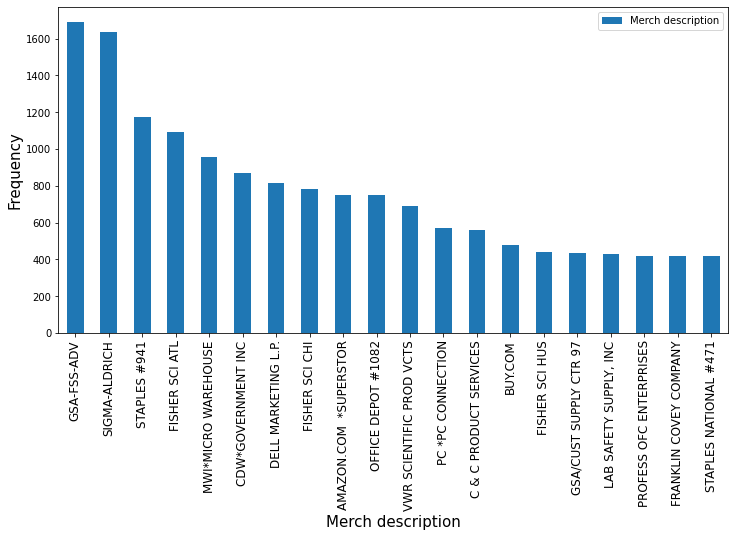

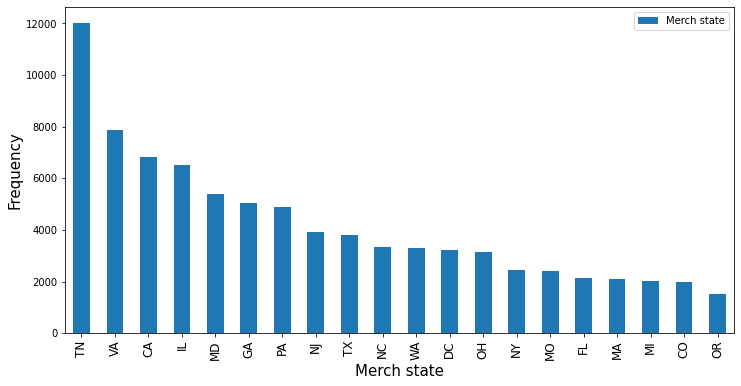

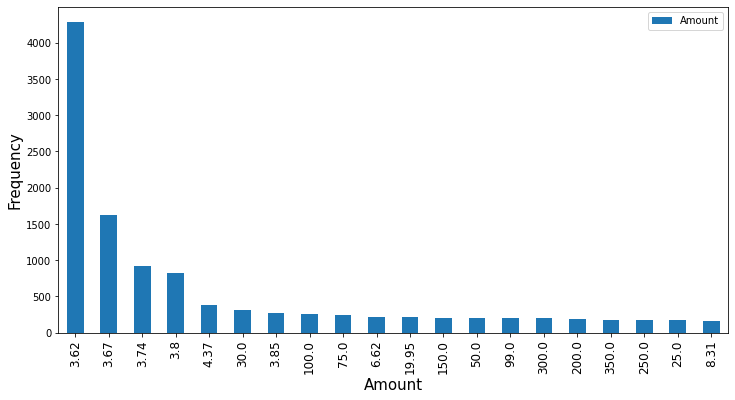

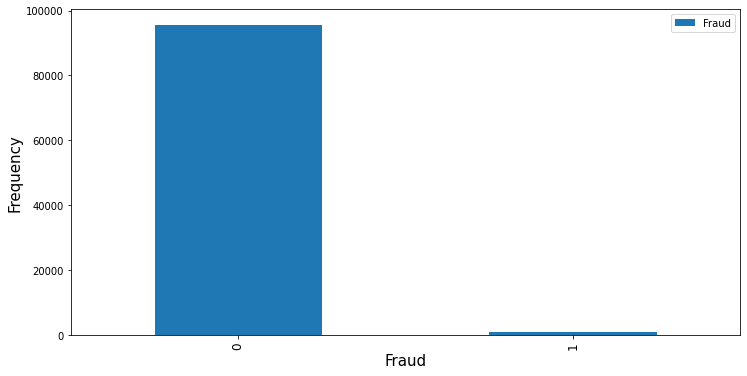

In [14]:
categoricalVar = credit_card.columns.tolist()
for col in categoricalVar:
    df = pd.DataFrame(credit_card[col].value_counts().sort_values(ascending=False).head(20))
    df.plot(kind='bar',figsize=(12,6))
    plt.xlabel(col,fontsize=15)
    plt.ylabel('Frequency',fontsize=15)
    plt.xticks(fontsize=12)

### CORRELATION ANALYSIS

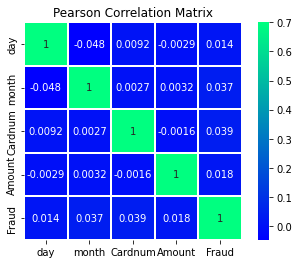

In [15]:
plt.title('Pearson Correlation Matrix')
sns.heatmap(credit_card.corr(),linewidths=0.25,vmax=0.7,square=True,cmap="winter",
            linecolor='w',annot=True);

The correlation plot shows no presence of multi collinearity amongst the features. All of these features does not show high correlation with the target class

### DISTRIBUTION OF TARGET CLASS

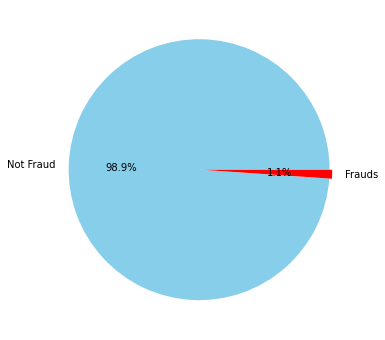

In [16]:
plt.figure(figsize=(10,6))
labels = ['Not Fraud' , 'Frauds']
explode = [.01,.01]
color = ['skyblue' , 'Red']
sizes = credit_card.Fraud.value_counts().values

plt.pie(sizes,explode,labels,autopct="%1.1f%%", colors = color)
plt.show()

The pie chart shows highly imbalanced dataset. 

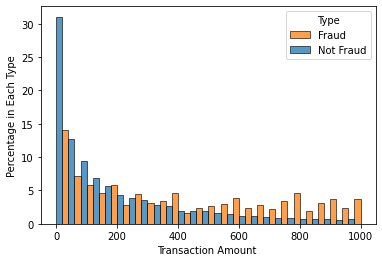

In [17]:
ax=sns.histplot(x='Amount',data=credit_card[credit_card.Amount<=1000],
                hue='Fraud',stat='percent',multiple='dodge',common_norm=False,bins=25)
ax.set_ylabel('Percentage in Each Type')
ax.set_xlabel('Transaction Amount ')
plt.legend(title='Type', labels=['Fraud', 'Not Fraud'])

### STATE VS FRAUD : let's also explore which geographies are more prone to fraud. 

Text(0.5, 1.0, 'The Percentage of Fraudulent over Non-Fraudulent Transcations in Each State')

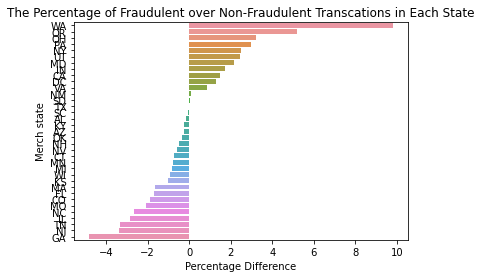

In [18]:
a=credit_card['Merch state'][credit_card.Fraud==0].value_counts(normalize=True)
a=a.to_frame()
a=a.reset_index()
a.columns = ['Merch state', 'Per']

b=credit_card['Merch state'][credit_card.Fraud==1].value_counts(normalize=True)
b=b.to_frame()
b=b.reset_index()
b.columns = ['Merch state', 'Per']

merged=a.merge(b,on='Merch state')
merged['diff']=merged['Per_y']-merged['Per_x']
merged['diff']=merged['diff']*100
merged=merged.sort_values('diff',ascending=False)

ax1=sns.barplot(data=merged, x='diff',y='Merch state')
ax1.set_xlabel('Percentage Difference')
ax1.set_ylabel('Merch state')
plt.title('The Percentage of Fraudulent over Non-Fraudulent Transcations in Each State')

### Monthly trends

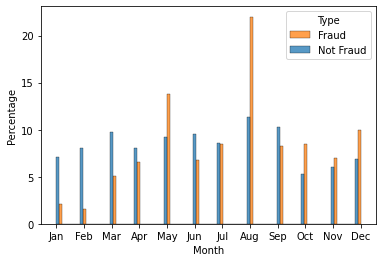

In [19]:
#month vs fraud
ax=sns.histplot(data=credit_card, x="month", hue="Fraud", common_norm=False,stat='percent',multiple='dodge')
ax.set_ylabel('Percentage')
ax.set_xlabel('Month')
plt.xticks(np.arange(1,13,1))
ax.set_xticklabels(["Jan","Feb","Mar","Apr","May","Jun","Jul",'Aug','Sep','Oct','Nov','Dec'])
plt.legend(title='Type', labels=['Fraud', 'Not Fraud'])

### Daily trend

/var/folders/n9/ckrqvsfj3t15h8cbxpgxnn300000gn/T/ipykernel_63518/3150562307.py:2: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['',"Mon","Tue","Wed","Thu","Fri","Sat","Sun"])


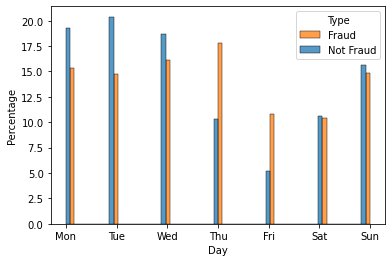

In [20]:
ax=sns.histplot(data = credit_card, x="day", hue="Fraud", common_norm=False,stat='percent',multiple='dodge')
ax.set_xticklabels(['',"Mon","Tue","Wed","Thu","Fri","Sat","Sun"])
ax.set_ylabel('Percentage')
ax.set_xlabel('Day')
plt.legend(title='Type', labels=['Fraud', 'Not Fraud'])

### ENCODING INDEPENDENT VARIABLE

In [21]:
le = LabelEncoder()
credit_card["Merchnum"] = le.fit_transform(credit_card['Merchnum'])
credit_card["Merch description"] = le.fit_transform(credit_card['Merch description'])
credit_card["Merch state"] = le.fit_transform(credit_card['Merch state'])
credit_card

,day,month,Cardnum,Merchnum,Merch description,Merch state,Amount,Fraud
0,4,1,5142190439,4975,4594,217,3.62,0
1,4,1,5142183973,6735,10393,189,31.42,0
2,4,1,5142131721,3340,8454,191,178.49,0
3,4,1,5142148452,4975,4598,217,3.62,0
4,4,1,5142190439,4975,4594,217,3.62,0
...,...,...,...,...,...,...,...,...
96748,4,12,5142276053,2241,1534,187,84.79,0
96749,4,12,5142225701,9925,7247,207,118.75,0
96750,4,12,5142226486,3226,11299,207,363.56,0
96751,4,12,5142244619,10571,2093,174,2202.03,0


In [22]:
credit_card.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96753 entries, 0 to 96752
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   day                96753 non-null  int64  
 1   month              96753 non-null  int64  
 2   Cardnum            96753 non-null  int64  
 3   Merchnum           96753 non-null  int64  
 4   Merch description  96753 non-null  int64  
 5   Merch state        96753 non-null  int64  
 6   Amount             96753 non-null  float64
 7   Fraud              96753 non-null  int64  
dtypes: float64(1), int64(7)
memory usage: 5.9 MB


### FEATURE SCALING 

In [23]:
# Scale amount by log
# Adding a small amount of 0.0001 to amount as log of zero is infinite.
credit_card['amount_log'] = np.log(credit_card.Amount + 0.0001)
credit_card['Cardnum_log'] = np.log(credit_card.Cardnum + 0.0001)
credit_card['Merchnum_log'] = np.log(credit_card.Merchnum + 0.0001)
credit_card['Merch description_log'] = np.log(credit_card['Merch description'] + 0.0001)
credit_card['Merch state_log'] = np.log(credit_card['Merch state'] + 0.0001)
credit_card

,day,month,Cardnum,Merchnum,Merch description,Merch state,Amount,Fraud,amount_log,Cardnum_log,Merchnum_log,Merch description_log,Merch state_log
0,4,1,5142190439,4975,4594,217,3.62,0,1.286502,22.360745,8.512181,8.432506,5.379898
1,4,1,5142183973,6735,10393,189,31.42,0,3.447448,22.360744,8.815073,9.248888,5.241748
2,4,1,5142131721,3340,8454,191,178.49,0,5.184533,22.360734,8.113726,9.042395,5.252274
3,4,1,5142148452,4975,4598,217,3.62,0,1.286502,22.360737,8.512181,8.433377,5.379898
4,4,1,5142190439,4975,4594,217,3.62,0,1.286502,22.360745,8.512181,8.432506,5.379898
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96748,4,12,5142276053,2241,1534,187,84.79,0,4.440179,22.360762,7.714678,7.335634,5.231109
96749,4,12,5142225701,9925,7247,207,118.75,0,4.777021,22.360752,9.202812,8.888343,5.332719
96750,4,12,5142226486,3226,11299,207,363.56,0,5.895945,22.360752,8.078998,9.332470,5.332719
96751,4,12,5142244619,10571,2093,174,2202.03,0,7.697135,22.360756,9.265870,7.646354,5.159056


In [24]:
ss = StandardScaler() # object of the class StandardScaler ()
credit_card['amount_scaled'] = ss.fit_transform(credit_card['Amount'].values.reshape(-1,1))
credit_card['Cardnum_scaled'] = ss.fit_transform(credit_card['Cardnum'].values.reshape(-1,1))
credit_card['Merchnum_scaled'] = ss.fit_transform(credit_card['Merchnum'].values.reshape(-1,1))
credit_card['Merch description_scaled'] = ss.fit_transform(credit_card['Merch description'].values.reshape(-1,1))
credit_card['Merch state_scaled'] = ss.fit_transform(credit_card['Merch state'].values.reshape(-1,1))

credit_card

,day,month,Cardnum,Merchnum,Merch description,Merch state,Amount,Fraud,amount_log,Cardnum_log,Merchnum_log,Merch description_log,Merch state_log,amount_scaled,Cardnum_scaled,Merchnum_scaled,Merch description_scaled,Merch state_scaled
0,4,1,5142190439,4975,4594,217,3.62,0,1.286502,22.360745,8.512181,8.432506,5.379898,-0.042401,-0.203839,-0.611361,-0.498148,0.974765
1,4,1,5142183973,6735,10393,189,31.42,0,3.447448,22.360744,8.815073,9.248888,5.241748,-0.039622,-0.319986,-0.176560,1.157666,-0.590932
2,4,1,5142131721,3340,8454,191,178.49,0,5.184533,22.360734,8.113726,9.042395,5.252274,-0.024924,-1.258580,-1.015281,0.604015,-0.479096
3,4,1,5142148452,4975,4598,217,3.62,0,1.286502,22.360737,8.512181,8.433377,5.379898,-0.042401,-0.958044,-0.611361,-0.497006,0.974765
4,4,1,5142190439,4975,4594,217,3.62,0,1.286502,22.360745,8.512181,8.432506,5.379898,-0.042401,-0.203839,-0.611361,-0.498148,0.974765
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96748,4,12,5142276053,2241,1534,187,84.79,0,4.440179,22.360762,7.714678,7.335634,5.231109,-0.034289,1.334030,-1.286785,-1.371884,-0.702767
96749,4,12,5142225701,9925,7247,207,118.75,0,4.777021,22.360752,9.202812,8.888343,5.332719,-0.030895,0.429566,0.611517,0.259375,0.415587
96750,4,12,5142226486,3226,11299,207,363.56,0,5.895945,22.360752,8.078998,9.332470,5.332719,-0.006429,0.443667,-1.043445,1.416361,0.415587
96751,4,12,5142244619,10571,2093,174,2202.03,0,7.697135,22.360756,9.265870,7.646354,5.159056,0.177306,0.769387,0.771108,-1.212270,-1.429698


In [25]:
from sklearn.preprocessing import MinMaxScaler

mm = MinMaxScaler() # object of the class StandardScaler ()
credit_card['amount_minmax'] = mm.fit_transform(credit_card['Amount'].values.reshape(-1,1))
credit_card['Cardnum_minmax'] = mm.fit_transform(credit_card['Cardnum'].values.reshape(-1,1))
credit_card['Merchnum_minmax'] = mm.fit_transform(credit_card['Merchnum'].values.reshape(-1,1))
credit_card['Merch description_minmax'] = mm.fit_transform(credit_card['Merch description'].values.reshape(-1,1))
credit_card['Merch state_minmax'] = mm.fit_transform(credit_card['Merch state'].values.reshape(-1,1))

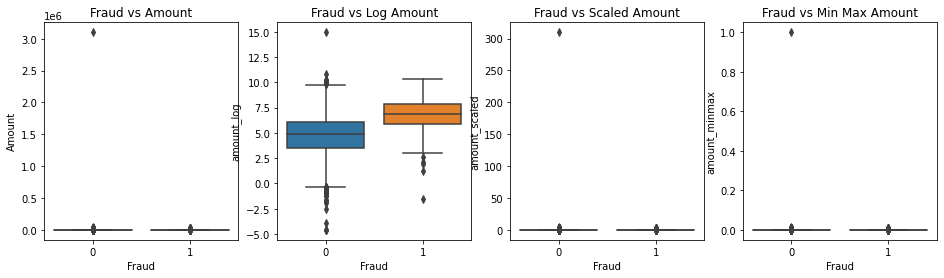

In [26]:
#Feature engineering to a better visualization of the values

# Let's explore the Amount by Class and see the distribuition of Amount transactions
fig , axs = plt.subplots(nrows = 1 , ncols = 4 , figsize = (16,4))

sns.boxplot(x ="Fraud",y="Amount",data=credit_card, ax = axs[0])
axs[0].set_title("Fraud vs Amount")

sns.boxplot(x ="Fraud",y="amount_log",data=credit_card, ax = axs[1])
axs[1].set_title("Fraud vs Log Amount")

sns.boxplot(x ="Fraud",y="amount_scaled",data=credit_card, ax = axs[2])
axs[2].set_title("Fraud vs Scaled Amount")

sns.boxplot(x ="Fraud",y="amount_minmax",data=credit_card, ax = axs[3])
axs[3].set_title("Fraud vs Min Max Amount")

# fig.suptitle('Amount by Class', fontsize=20)
plt.show()


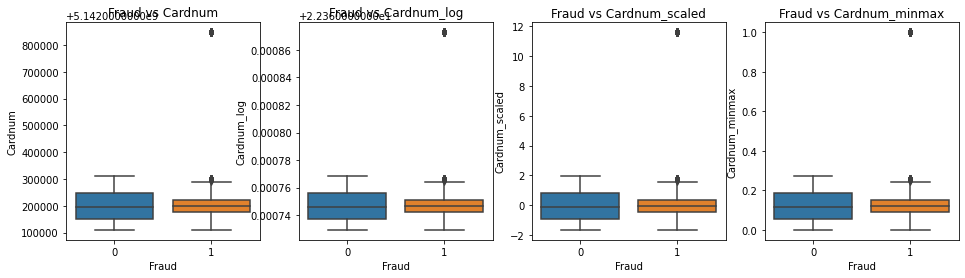

In [27]:
fig , axs = plt.subplots(nrows = 1 , ncols = 4 , figsize = (16,4))

sns.boxplot(x ="Fraud",y="Cardnum",data=credit_card, ax = axs[0])
axs[0].set_title("Fraud vs Cardnum")

sns.boxplot(x ="Fraud",y="Cardnum_log",data=credit_card, ax = axs[1])
axs[1].set_title("Fraud vs Cardnum_log")

sns.boxplot(x ="Fraud",y="Cardnum_scaled",data=credit_card, ax = axs[2])
axs[2].set_title("Fraud vs Cardnum_scaled")

sns.boxplot(x ="Fraud",y="Cardnum_minmax",data=credit_card, ax = axs[3])
axs[3].set_title("Fraud vs Cardnum_minmax")

# fig.suptitle('Amount by Class', fontsize=20)
plt.show()


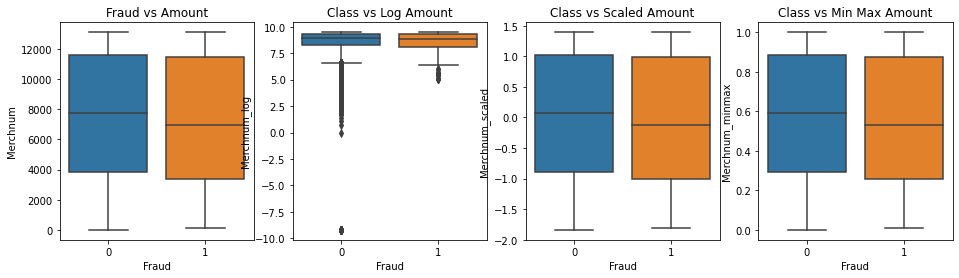

In [28]:
fig , axs = plt.subplots(nrows = 1 , ncols = 4 , figsize = (16,4))

sns.boxplot(x ="Fraud",y="Merchnum",data=credit_card, ax = axs[0])
axs[0].set_title("Fraud vs Amount")

sns.boxplot(x ="Fraud",y="Merchnum_log",data=credit_card, ax = axs[1])
axs[1].set_title("Class vs Log Amount")

sns.boxplot(x ="Fraud",y="Merchnum_scaled",data=credit_card, ax = axs[2])
axs[2].set_title("Class vs Scaled Amount")

sns.boxplot(x ="Fraud",y="Merchnum_minmax",data=credit_card, ax = axs[3])
axs[3].set_title("Class vs Min Max Amount")

# fig.suptitle('Amount by Class', fontsize=20)
plt.show()

We can see a slight difference in the log amount of our two Classes

In [29]:
df = credit_card[['day', 'month', 'Cardnum_minmax','Merchnum_log','Merch description_log', 'Merch state_log', 'amount_log','Fraud']]
df

,day,month,Cardnum_minmax,Merchnum_log,Merch description_log,Merch state_log,amount_log,Fraud
0,4,1,0.109083,8.512181,8.432506,5.379898,1.286502,0
1,4,1,0.100314,8.815073,9.248888,5.241748,3.447448,0
2,4,1,0.029454,8.113726,9.042395,5.252274,5.184533,0
3,4,1,0.052143,8.512181,8.433377,5.379898,1.286502,0
4,4,1,0.109083,8.512181,8.432506,5.379898,1.286502,0
...,...,...,...,...,...,...,...,...
96748,4,12,0.225186,7.714678,7.335634,5.231109,4.440179,0
96749,4,12,0.156902,9.202812,8.888343,5.332719,4.777021,0
96750,4,12,0.157967,8.078998,9.332470,5.332719,5.895945,0
96751,4,12,0.182557,9.265870,7.646354,5.159056,7.697135,0


In [30]:
print(df['Fraud'].value_counts())
print('\n')
print(df['Fraud'].value_counts(normalize=True))

0    95694
1     1059
Name: Fraud, dtype: int64


0    0.989055
1    0.010945
Name: Fraud, dtype: float64


In [31]:
#First Method of solving this problem which comes in mind will be by 
#taking same number of records of the majority class as the minority class
fraud_data = df.loc[df["Fraud"] == 1]
non_fraud_data = df.loc[df["Fraud"] == 0][:1059]

#concating the above dataframes to get a single dataframe
normal_distributed_df = pd.concat([fraud_data, non_fraud_data])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)
# setting up separate dataframes for fraud and non_fraud data for detailed analysis and comparison

print("Fraud Data Shape: ", fraud_data.shape)
print("Non-Fraud Data Shape: ", non_fraud_data.shape)

Fraud Data Shape:  (1059, 8)
Non-Fraud Data Shape:  (1059, 8)


In [63]:
#splitting the dataset
X_train, X_test = train_test_split(new_df, test_size=0.2, random_state=42)

 
pd.DataFrame(fraud_data).to_csv("./api/models/fraud_data.csv", index = None)
pd.DataFrame(X_test).to_csv("./api/models/X_test.csv", index = None)
print(X_test)

X_train = X_train[X_train.Fraud == 0]
X_train = X_train.drop(['Fraud'], axis=1)

y_test = X_test['Fraud']
X_test = X_test.drop(['Fraud'], axis=1)

X_train = X_train
X_test = X_test


X_train.shape
X_test.shape

       day  month  Cardnum_minmax  Merchnum_log  Merch description_log  \
95234    2     12        0.068859      5.505332               7.997663   
625      1      1        0.195043      6.794587               8.698014   
84       6      1        0.199830      9.080915               8.145260   
70701    0      9        0.150417      6.492240               9.373054   
575      1      1        0.123078      9.065199               9.259797   
...    ...    ...             ...           ...                    ...   
62309    2      8        0.118744      9.032648               8.438583   
36646    0      5        0.118944      8.962776               8.487352   
62696    3      8        0.118744      7.031741               9.053102   
50516    0      7        0.090775      8.099554               9.039671   
907      2      1        0.146653      9.087834               8.197814   

       Merch state_log  amount_log  Fraud  
95234         5.347108    5.451897      1  
625           5.347108 

(424, 7)

In [33]:
X_train.shape

(851, 7)

### UNDERCOMPLETE AUTOENCODER

The Autoencoder model for anomaly detection has some steps as follows: 

Step 1 is the encoder step. The essential information is extracted by a neural network model in this step.

Step 2 is the decoder step. In this step, the model reconstructs the data using the extracted information.

Step 3: Iterate step 1 and step 2 to adjust the model to minimize the difference between input and reconstructed output, until we get good reconstruction results for the training dataset.

Step 4: Make predictions on a dataset that includes outliers.

Step 5: Set up a threshold for outliers/anomalies by comparing the differences between the autoencoder model reconstruction value and the actual value.

Step 6: Identify the data points with the difference higher than the threshold to be outliers or anomalies.

In [34]:
# 'tanh' is used for the activation function of the encoded network 
# because it has big learning steps and results in strong or higher gradients

#relu is used on the bottle neck (latent low representation) 
#because model performance is better when trained with relu

#sigmoid is used for binary classification and since we have 
#fraud and non fraudclass then it is good for this problem

#In the input layer, we specified the shape of the dataset. 

In [35]:
n_features = (X_train.shape[1])
encoder = models.Sequential(name='encoder')
encoder.add(layer=layers.Dense(units=200, activation=activations.tanh, activity_regularizer=regularizers.l1(1e-3),input_shape=[n_features]))
encoder.add(layer=layers.Dense(units=100, activation=activations.tanh))
encoder.add(layer=layers.Dense(units=5, activation=activations.relu))

decoder = models.Sequential(name='decoder')
decoder.add(layer=layers.Dense(units=100, activation=activations.tanh, input_shape=[5]))
decoder.add(layer=layers.Dense(units=200, activation=activations.tanh))
decoder.add(layer=layers.Dense(units=n_features, activation=activations.sigmoid))

autoencoder = models.Sequential([encoder, decoder])

autoencoder.compile(loss=losses.MSE,optimizer=optimizers.Adam(),metrics=[metrics.mean_squared_error])

2022-11-21 18:08:13.878037: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [36]:
# compiling the auto encoder model  with the optimizer of adam and the loss of mse (Mean squared Error).
#autoencoder.compile(optimizer="adam", loss="mse", metrics=['AUC'])

#When fitting the autoencoder model, we can see that the input and output datasets are the same,
#which is the dataset that contains only the normal data points.

#The epochs of 50 and batch_size of 32 mean the model uses 32 datapoints to update the weights in each iteration, 
#and the model will go through the whole training dataset 50 times.

#shuffle=True will shuffle the dataset before each epoch.

# training the auto encoder model on non fraud data 
history = autoencoder.fit(X_train, X_train,batch_size=256,epochs=80,shuffle=True,validation_data=(X_test, X_test))

Epoch 1/80
4/4 [==============================] - 1s 66ms/step - loss: 25.1670 - mean_squared_error: 25.0399 - val_loss: 28.8688 - val_mean_squared_error: 28.7348
Epoch 2/80
4/4 [==============================] - 0s 11ms/step - loss: 22.9559 - mean_squared_error: 22.8287 - val_loss: 27.7167 - val_mean_squared_error: 27.5819
Epoch 3/80
4/4 [==============================] - 0s 11ms/step - loss: 22.3285 - mean_squared_error: 22.2005 - val_loss: 27.4649 - val_mean_squared_error: 27.3299
Epoch 4/80
4/4 [==============================] - 0s 12ms/step - loss: 22.2299 - mean_squared_error: 22.1021 - val_loss: 27.3769 - val_mean_squared_error: 27.2426
Epoch 5/80
4/4 [==============================] - 0s 10ms/step - loss: 22.2065 - mean_squared_error: 22.0797 - val_loss: 27.3377 - val_mean_squared_error: 27.2045
Epoch 6/80
4/4 [==============================] - 0s 11ms/step - loss: 22.1975 - mean_squared_error: 22.0724 - val_loss: 27.3174 - val_mean_squared_error: 27.1859
Epoch 7/80
4/4 [======

In [57]:
import joblib

# Save Model
model = autoencoder
filename = "./api/models/Completed_model.joblib"
joblib.dump(model, filename)

# Save columns in order
# print("The X_Test", X_test.columns)
# print("The X_train", X_train.columns)
pd.DataFrame(X_train.columns).to_csv("./api/models/feature_list.csv", index = None)

pd.DataFrame(X_test).to_csv("./api/models/X_test.csv", index = None)

# Save data types of train set
pd.DataFrame(X_train.dtypes).reset_index().to_csv("./api/models/data_types.csv", index = None)

pred1 = autoencoder.predict(X_test)
print(pred1)
pred1 = pd.DataFrame(pred1).to_csv('./api/models/data1.csv')

loaded_model = joblib.load(filename)
result = loaded_model.evaluate(X_test, y_test)
print("Evaluation From traind model:", result)


INFO:tensorflow:Assets written to: ram://c9cf2349-457f-4a99-95d9-8c3d2cb7fb1c/assets
14/14 [==============================] - 0s 1ms/step
[[0.99036217 0.9531359  0.1975342  ... 0.9947238  0.9916337  0.99355066]
 [0.99980116 0.9939256  0.11943313 ... 0.9999477  0.9998784  0.99991494]
 [0.9998766  0.99530846 0.11937736 ... 0.9999734  0.99992895 0.9999493 ]
 ...
 [0.9930802  0.95884234 0.18903288 ... 0.99627864 0.9940845  0.99559   ]
 [0.97276443 0.910034   0.25124148 ... 0.982451   0.97546554 0.9797981 ]
 [0.99983764 0.99457246 0.11880162 ... 0.9999605  0.9999016  0.99993014]]
14/14 [==============================] - 0s 2ms/step - loss: 0.5262 - mean_squared_error: 0.4714
Evaluation From traind model: [0.526172399520874, 0.47143757343292236]


Text(0.5, 1.0, 'Loss Curves')

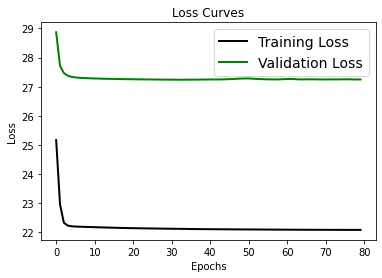

In [38]:
# Loss curve

plt.plot(history.history["loss"], "black", linewidth=2.0)
plt.plot(history.history["val_loss"], "green", linewidth=2.0)
plt.legend(["Training Loss", "Validation Loss"], fontsize=14)
plt.xlabel("Epochs", fontsize=10)
plt.ylabel("Loss", fontsize=10)
plt.title("Loss Curves", fontsize=12)

In [39]:
#we have an autoencoder model, let's use it to predict the outliers.
#Firstly, we use .predict to get the reconstruction value for the testing data 
#set containing the usual data points and the outliers.


# Predict anomalies/outliers in the training dataset
prediction = autoencoder.predict(X_test)

print(prediction)

14/14 [==============================] - 0s 1ms/step
[[0.99036217 0.9531359  0.1975342  ... 0.9947238  0.9916337  0.99355066]
 [0.99980116 0.9939256  0.11943313 ... 0.9999477  0.9998784  0.99991494]
 [0.9998766  0.99530846 0.11937736 ... 0.9999734  0.99992895 0.9999493 ]
 ...
 [0.9930802  0.95884234 0.18903288 ... 0.99627864 0.9940845  0.99559   ]
 [0.97276443 0.910034   0.25124148 ... 0.982451   0.97546554 0.9797981 ]
 [0.99983764 0.99457246 0.11880162 ... 0.9999605  0.9999016  0.99993014]]


In [40]:
mse = np.mean(np.power(X_test - prediction, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})

In [41]:
error_df

,reconstruction_error,true_class
95234,33.043216,1
625,19.354396,0
84,25.102777,0
70701,35.201147,1
575,24.991009,0
...,...,...
62309,32.776058,1
36646,26.226202,1
62696,28.906763,1
50516,30.078243,1


In [42]:
error_df.describe()

,reconstruction_error,true_class
count,424.000000,424.000000
mean,27.192731,0.509434
std,6.809678,0.500502
min,10.810708,0.000000
25%,21.655826,0.000000
50%,26.246683,1.000000
75%,32.742380,1.000000
max,46.833586,1.000000


In [43]:
# Get the mean squared error between actual and reconstruction/prediction
prediction_loss = tf.keras.losses.mse(prediction, X_test)
prediction_loss

<tf.Tensor: shape=(424,), dtype=float64, numpy=
array([33.04321562, 19.35439647, 25.10277677, 35.20114729, 24.99100923,
       34.36535565, 35.89193769, 19.36071122, 34.57177732, 31.81954403,
       25.76244327, 41.97372004, 34.97386329, 22.67990216, 36.75537059,
       23.452657  , 38.54534668, 20.42520287, 20.7127539 , 28.44325895,
       39.70710072, 21.59944824, 26.53878524, 21.80585956, 20.38586738,
       22.62793664, 18.7281663 , 18.7281663 , 31.57937041, 34.63572687,
       38.19563676, 24.2806314 , 31.26597848, 24.3030869 , 32.8621254 ,
       24.54974395, 21.80174601, 31.847097  , 33.11632966, 39.91139911,
       24.91820129, 33.75502822, 25.70760981, 18.72689085, 27.13134276,
       26.91837818, 44.03587467, 36.88807091, 36.20315893, 29.32159283,
       26.47767099, 35.78088808, 25.43645382, 27.04873036, 22.3939687 ,
       22.44384574, 40.64122431, 21.60685374, 37.9392384 , 33.5846699 ,
       23.349493  , 30.73954301, 21.48522313, 24.48643447, 33.83536172,
       20.609181

In [44]:
# Check the prediction loss threshold for 50% of outliers
loss_threshold = np.percentile(prediction_loss, 50)
print(f'The prediction loss threshold for 50% of outliers is {loss_threshold:.2f}')

The prediction loss threshold for 50% of outliers is 26.25


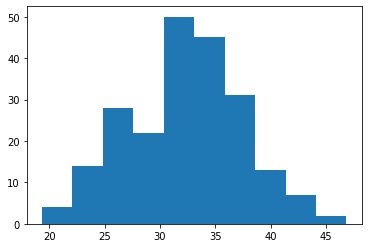

In [45]:
#Reconstruction error with fraud

fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1.0]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)

In [46]:
# Check the model performance at 50% threshold
threshold_prediction = [0 if i < loss_threshold else 1 for i in prediction_loss]
threshold_prediction

[1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,


In [47]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

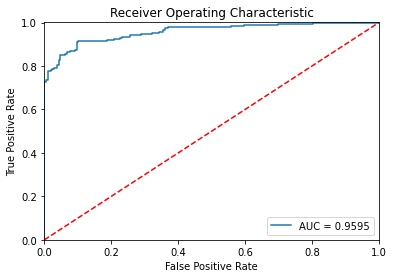

In [48]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

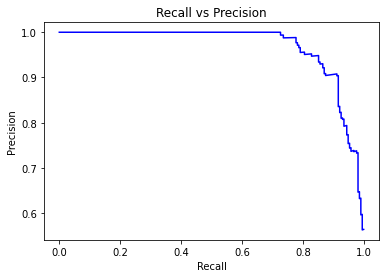

In [49]:
precision, recall,th= precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

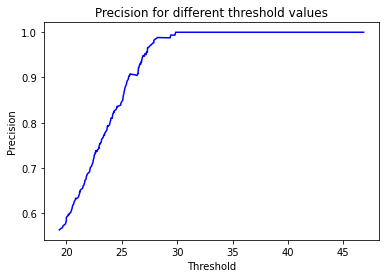

In [50]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

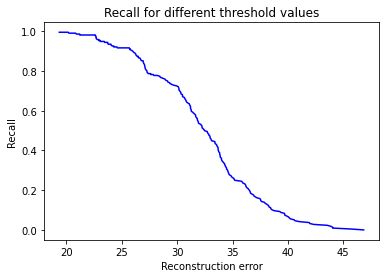

In [51]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

In [52]:
threshold = 26.20

In [53]:
pred_y = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]

In [54]:
predictions = pd.DataFrame({'true': error_df.true_class,
                           'predicted': pred_y})

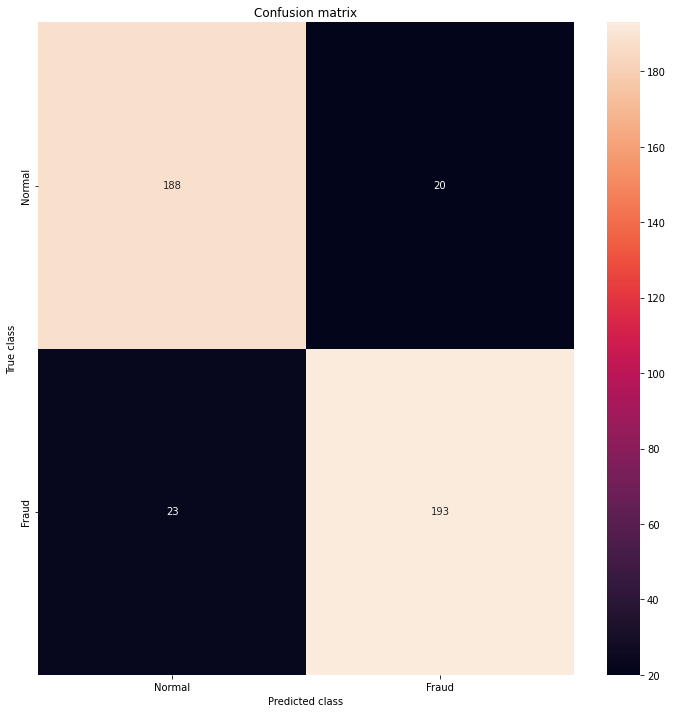

In [55]:
conf_matrix = confusion_matrix(error_df.true_class, pred_y)
conf_matrix
plt.figure(figsize=(12, 12))
LABELS = ['Normal', 'Fraud']
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [56]:
# Check the prediction performance
print(classification_report(y_test, pred_y))

              precision    recall  f1-score   support

           0       0.89      0.90      0.90       208
           1       0.91      0.89      0.90       216

    accuracy                           0.90       424
   macro avg       0.90      0.90      0.90       424
weighted avg       0.90      0.90      0.90       424

